In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir(r"C:\Users\hp\Desktop\customer_churn_prediction")

# Load the cleaned data from Step 2
df = pd.read_csv('data/processed/cleaned_churn_data.csv')

print("Shape:", df.shape)
df.head()

Shape: (7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Map Churn from 'Yes'/'No' to 1/0
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Confirm
df['Churn'].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [4]:
X = df.drop('Churn', axis=1)  # Features
y = df['Churn']               # Target

In [5]:
# Get list of categorical columns (object or category dtype)
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical Columns:", cat_cols)
print("Numerical Columns:", num_cols)

Categorical Columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical Columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [6]:
# Apply one-hot encoding
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True, prefix_sep='_')

# Check shape
print("Before encoding:", X.shape)
print("After encoding:", X_encoded.shape)

Before encoding: (7043, 19)
After encoding: (7043, 30)


In [7]:
X_encoded['AvgMonthlySpend'] = X_encoded['TotalCharges'] / (X_encoded['tenure'] + 1)
# +1 to avoid division by zero

In [8]:
X_encoded['TenureGroup'] = pd.cut(
    X_encoded['tenure'],
    bins=[0, 12, 36, 72],
    labels=['New (0-1yr)', 'Mid (1-3yrs)', 'Loyal (3-6yrs)'],
    include_lowest=True
)

# One-hot encode the group
X_encoded = pd.get_dummies(X_encoded, columns=['TenureGroup'], prefix='Tenure')

In [9]:
X_encoded['IsHighSpender'] = (X_encoded['MonthlyCharges'] > X_encoded['MonthlyCharges'].quantile(0.75)).astype(int)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Keep same churn ratio in both sets
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (5634, 35)
Test set size: (1409, 35)


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for clarity (optional)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [13]:
# Save processed datasets
X_train_scaled.to_csv('data/processed/X_train_scaled.csv', index=False)
X_test_scaled.to_csv('data/processed/X_test_scaled.csv', index=False)
y_train.to_csv('data/processed/y_train.csv', index=False)
y_test.to_csv('data/processed/y_test.csv', index=False)

# Save the scaler
import joblib
joblib.dump(scaler, 'models/scaler.pkl')

# Save feature names (important for prediction later)
joblib.dump(X_train.columns.tolist(), 'models/feature_names.pkl')

['models/feature_names.pkl']

C:\Users\hp\AppData\Local\Temp\ipykernel_14984\1143769846.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette='RdYlGn')


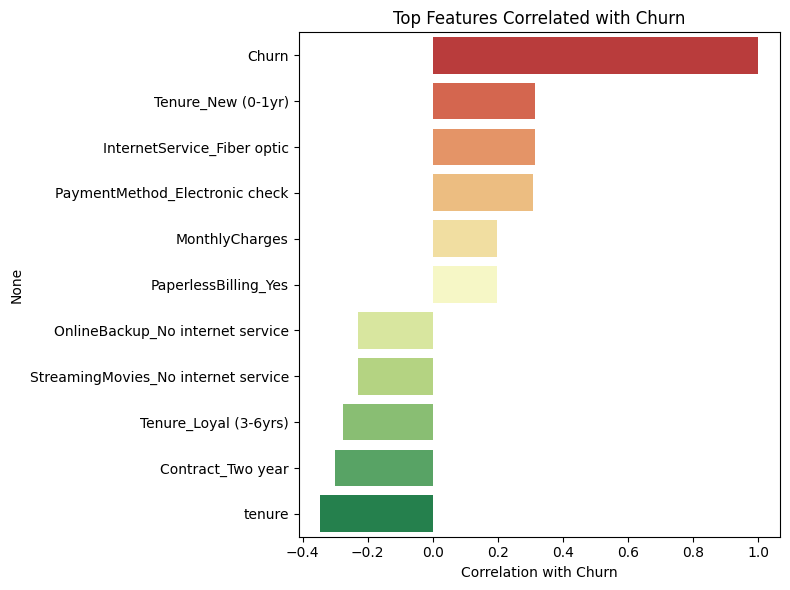

In [14]:
# Combine X_train and y_train for correlation
df_corr = X_train_scaled.copy()
df_corr['Churn'] = y_train.values

# Compute correlation with Churn
churn_corr = df_corr.corr()['Churn'].sort_values(ascending=False)

# Top 10 positive and negative
top_corr = pd.concat([churn_corr.head(6), churn_corr.tail(5)])

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=top_corr.values, y=top_corr.index, palette='RdYlGn')
plt.title('Top Features Correlated with Churn')
plt.xlabel('Correlation with Churn')
plt.tight_layout()
plt.savefig('reports/images/top_features_correlation.png', bbox_inches='tight')
plt.show()